## Установка Catalist

In [1]:
%%capture
!pip install catalyst

## Импорты

In [2]:
import os
import numpy as np
import warnings
from IPython.display import clear_output
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from catalyst.utils import set_global_seed
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
from typing import cast
import pandas as pd
from torch.optim import lr_scheduler
from torch import Tensor
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm_notebook
import torch.nn.functional as F
from torchvision import models
import copy
import torch.optim as optim
import time
from torchsummary import summary  # для вывода информации о модели

from matplotlib import rcParams


sns.set_style('darkgrid')

warnings.filterwarnings("ignore")
np.random.seed(42)
set_global_seed(42)

C:\Users\drug1\AppData\Local\Temp\ipykernel_22592\534387239.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# устанавливаем device если gpu или cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.0.1+cu118
версия  cuDNN:           8700
Tue Sep 12 12:11:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8              21W / 170W |    880MiB / 12288MiB |      4%      Default |
|                                         |                  

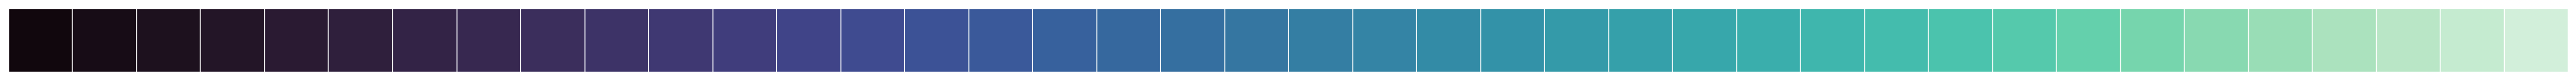

In [4]:
current_palette = sns.color_palette('mako', 40)
sns.palplot(current_palette)

#### Дополнительные функции для исследования

In [5]:
def research_train(epochs, data_tr, data_val, verbose=None):

    """
    _________________________________________________________________________________
    
    Дополнительная функция обучения. Предназначена для исследовательской части работы
    Не используется в основной - для основной части написана функция train
    Позволяет собирать историю для валидации и обучения. Сохраняет целевые метрики, 
    а также значения функции потерь
    _________________________________________________________________________________


    """

    
    history = []
    loss = [bce_loss_torch, dice_loss, focal_loss, lovasz_hinge]
    for experiment, los in enumerate(loss):
        with torch.no_grad():
            torch.cuda.empty_cache()

        loss_fn = los
          # модель Unet версии 1
        model = UNet().to(device)
        print(f'\nЭксперимент {experiment + 1}. Функция потерь {los.__name__}')


        with torch.no_grad():
            torch.cuda.empty_cache()

        opt = optim.Adam(model.parameters(), lr=1e-4)
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=20, gamma=0.1)



        x_val, y_val = next(iter(data_val))

        with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
            for epoch in range(epochs):

                set_global_seed(42 + epoch)
                avg_loss_train = 0
                avg_loss_val = 0

                model.train()

                for x_batch, y_batch in data_tr:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)

                    opt.zero_grad()

                    y_pred = model(x_batch)
                    y_batch = y_batch
                    loss =  loss_fn(y_batch, y_pred)

                    loss.backward()
                    opt.step()

                    avg_loss_train += loss / len(data_tr)



                    exp_lr_scheduler.step()

            
                with torch.no_grad():

                    inputs = x_val.to(device)
                    model.eval()
                    y_hat = model(inputs)
                    loss_val =  loss_fn(y_val, y_hat)
                    avg_loss_val += loss_val / len(data_val)


                avg_scores_t = score_model(model, iou_pytorch, data_tr)
                avg_scores_v = score_model(model, iou_pytorch, data_val)

                pbar_outer.update(1)
                history.append((experiment + 1, los.__name__, loss, loss_val, avg_scores_t, avg_scores_v))   
                if epoch % verbose == 0 or epoch == epochs:
                    print(f'epoch {epoch + 1} | train_loss {loss:.3f} | val_loss {loss_val:.3f}  | TrainIoU {avg_scores_t:.3f} | ValIoU {avg_scores_v:.3f}')
        print(f'epoch {epoch + 1} | train_loss {loss:.3f} | val_loss {loss_val:.3f}  | TrainIoU {avg_scores_t:.3f} | ValIoU {avg_scores_v:.3f}')
    return history

In [6]:
def make_report(history):
    """
    _________________________________________________________________________________
    
    Дополнительная функция обучения для подготовки отчета
    _________________________________________________________________________________


    """
    experiment, loss_name, loss, loss_val, avg_scores_t, avg_scores_v = zip(*history)
    return (pd.DataFrame({ 
                        'Experiment_number': experiment,
                        'Loss_name' : loss_name ,
                        'Train_loss' : np.array(loss).astype(float),
                        'Val_loss' : np.array(loss_val),
                        'Train_IOU': avg_scores_t,
                        'Val_IOU': avg_scores_v})

            )

## Загрузка данных
скачивание датасета с  [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html)  
фотографии двух типов поражений кожи: меланома и родинки.

In [7]:
images = []
lesions = []

root = 'dataset1'

for root, dirs, files in os.walk(os.path.join(root)):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [8]:
# Гиперпараметры
size = (256, 256)
batch_size = 15
max_epochs = 20
step_size = 17
patience = 10

In [9]:
# приведём размеры к одному
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [10]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


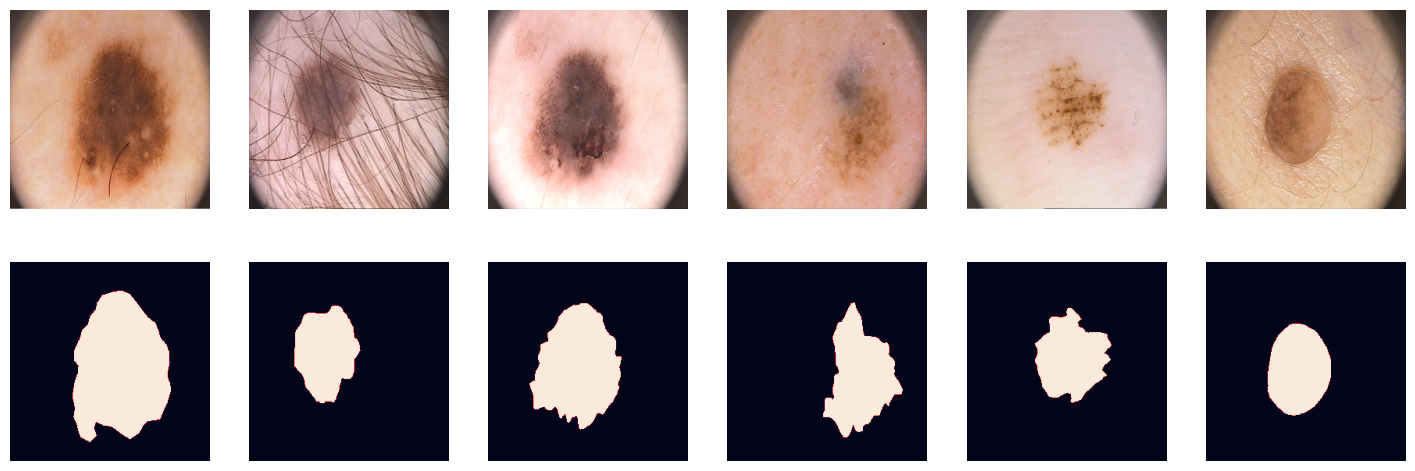

In [11]:
# Просмотр примеров изображений и масок
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [12]:
print(X[0].shape)

(256, 256, 3)


## Подготовка датасета

In [13]:
# деление датасета на тренировочный, валидационный и тестовый набор
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [160, 190])
print(len(tr), len(val), len(ts))

160 30 10


## DataLoader

In [14]:
print(device)

cuda


In [15]:

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=5, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=5, shuffle=True)

## Для статистики

In [16]:
IoU_validation = []
IoU_test = []
model_name = []
loss_name = []
train_time = []
prediction_time = []

In [17]:
rcParams['figure.figsize'] = (14,6)

## Метрика

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$  

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины,  
тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

In [18]:
# Функция метрики
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte() 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-9
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))    
    
    iou = (intersection + SMOOTH) / (union + SMOOTH) 
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    
    return thresholded.mean()

## Функции потерь




In [19]:
def bce_loss_torch(y_real, y_pred):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    y_pred = y_pred.type(torch.float32)
    y_real = y_real.type(torch.float32)

    loss = F.relu(y_pred) - y_real * y_pred + torch.log(1. + torch.exp(-abs(y_pred)))
    return torch.mean(loss)


def dice_loss(y_real, y_pred):

    SMOOTH = 1e-8

    y_pred = F.sigmoid(y_pred)

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)   

    num = 2. * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred**2) + torch.sum(y_real**2)
    res = (num) / (den + SMOOTH)

    return 1. - res



def focal_loss(y_real, y_pred):

    GAMMA = 2
    ALPHA = .8
    y_pred = y_pred.type(torch.float32)
    y_real = y_real.type(torch.float32)

    BCE = bce_loss_torch(y_real, y_pred)
    pt = torch.exp(-BCE)
    focal_loss = ALPHA * (1. - pt)**GAMMA * BCE

    return focal_loss


# https://arxiv.org/pdf/1705.08790.pdf
def grad_lovasz(sorted_errors):

    err_cumm = sorted_errors.float().cumsum(0)
    opp_err_cumm = (1 - sorted_errors).float().cumsum(0)
    p = len(sorted_errors)
    err = sorted_errors.sum()
    intersection = err - err_cumm
    union = err + opp_err_cumm
    grad = 1 - intersection / union
    if p > 1:
        grad[1:p] = grad[1:p] - grad[0:p-1]
    return grad


# https://arxiv.org/pdf/1512.07797.pdf. 
def lovasz_hinge(y_real, y_pred):

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    sgn = 2 * y_real.float() - 1
    errs = (1 - y_pred * torch.tensor(sgn, requires_grad=True))
    sorted_errors, indices = torch.sort(errs, dim=0, descending=True)
    indices = indices.data
    errs_for_grad = y_real[indices]
    grad = grad_lovasz(errs_for_grad)
    loss = torch.dot(F.relu(sorted_errors), torch.tensor(grad, requires_grad=True))
    return loss



# Пути к сохранённым моделям
pretrained_model_SegNet = 'model_SegNet_pretrained_1.pth'

filename_model_SegNet1 = 'model_SegNet_1.pth'


pretrained_model_Unet1 = 'model_Unet_pretrained_1.pth'
pretrained_model_Unet2 = 'model_Unet2_pretrained_1.pth'

filename_model_Unet1 = 'model_Unet1_1.pth'
filename_model_Unet2 = 'model_Unet2_1.pth'


## Функция загрузки модели

In [20]:
def load_models(model_filename, name_Net):
    # Создание модели
    model = name_Net().to(device)

    # Загрузка  модели если ранее сохранена была
    if os.path.isfile(model_filename):
        # Попытка загрузить модель
        try:
            model.load_state_dict(torch.load(model_filename))
            print("Модель успешно загружена и готова к использованию.")
            return model
        except Exception as e:
            print(f"Произошла ошибка при загрузке модели: {e}")
    else:
        print("Файл модели не существует.")
        return model
    

## Функции тренировки, предсказания

In [21]:
def train(model, patch_name_model, opt, loss_fn, metric, epochs, data_tr, data_val, scheduler=None, patience=None):
    x_val, y_val = next(iter(data_val))
    # model  - Модель
    # patch_name_model - путь для сохранения модели сети
    # loss_fn - Функция потерь
    # metric - Метрика
    # epochs - Количество эпох
    # data_tr, data_val - наборы данных 
    # scheduler - Планировщик (управляет скоростью обучения)
    # patience  - терпимость, через сколько эпох остановить обучение, если нет улучшения

    best_val_loss =  np.inf
    patience_count = 0
    best_model = copy.deepcopy(model.state_dict())
    
    # Цикл обучения
    for epoch in range(epochs):  # Проход по эпохам
        # set_global_seed(42 + epoch)
        model.train()   # Переводим модель в состояние тренировки
        print(f'Epoch {epoch+1}/{epochs}')  # Выводим номер текущей  эпохи
        
        # Создаём прогресбар тренировки
        progress_bar_train = tqdm(data_tr, total=len(data_tr), desc='Тренировка', leave=True)
        
        # Запускаем обучение
        avg_loss = 0  # Инициализация переменной avg_loss перед использованием
        avg_IoU = 0
        for x_batch, y_batch in progress_bar_train:  #  Проход по батчам - ТРЕНИРОВКА
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)              
                
                opt.zero_grad()
                
                y_pred = model(x_batch)  # Предсказываем 

                loss =  loss_fn(y_batch, y_pred)
                          
                loss.backward()  # Вычисляем градиенты функции потерь (loss) для оптимизации
                opt.step()  # делаем шаг оптимизации
                
                iou = metric(torch.round(F.sigmoid(y_pred)), y_batch) #  функция расчета IоU 
       
                avg_loss += loss  # Добавление текущего лосса к avg_loss
                avg_IoU += iou
                                
                # print("LOSS", loss)
                # print("avg_loss", avg_loss)
                # print("avg_IoU", avg_IoU)
                
                progress_bar_train.set_postfix(loss=loss.item(), IoU=iou.mean().item())  # Изменяем прогресбар     
                
        avg_loss /= len(data_tr)  # Усреднение лосса по всем пакетам данных
        avg_IoU /= len(data_tr)   # Усреднение IoU по всем пакетам данных
        
           # tqdm-объект для отслеживания прогресса валидации
        progress_bar_val = tqdm(data_val, total=len(data_val), desc='Валидация', leave=True)
        
        with torch.no_grad():
            model.eval() 
            avg_loss_val = 0  # Инициализация переменной avg_loss перед использованием
            avg_IoU_val = 0
            for x_batch, y_batch in progress_bar_val:  #  Проход по батчам - ТРЕНИРОВКА
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device) 
                    y_pred = model(x_batch)  # Предсказываем 
                    
                    loss1 =  loss_fn(y_batch, y_pred)  # функция потерь
                    iou1 = metric(torch.round(F.sigmoid(y_pred)), y_batch) #  функция расчета IоU
                    
                    avg_loss_val += loss1  # Добавление текущего лосса к avg_loss
                    avg_IoU_val += iou1
                    
#                     y_pred = torch.round(F.sigmoid(model(x_batch)))  # Предсказываем                     
#                     loss =  loss_fn(y_batch, y_pred)                    
#                     IoU1 = metric(y_pred.cpu(), y_batch.cpu()).mean().item()
                    progress_bar_val.set_postfix(loss=loss1.item(), IoU=iou1.mean().item())  # Изменяем прогресбар
    
                    # progress_bar_val.set_postfix(loss=loss.item(), IoU=IoU1)  # Изменяем прогресбар

            avg_loss_val /= len(data_val)  # Усреднение лосса по всем пакетам данных
            avg_IoU_val = avg_IoU_val/len(data_val)   # Усреднение IoU по всем пакетам данных
        
        
        # шаг шедулера, если указан
        if scheduler is not None:
            scheduler.step()
        
        # проверка лосса
        if(best_val_loss > avg_loss_val):
            patience_count = 0
            best_val_loss = loss
            best_model = copy.deepcopy(model.state_dict())
        if patience is not None:
            if(patience_count > patience):
                model.load_state_dict(best_model) 
                break
            patience_count += 1
        
        
        with torch.no_grad():
            inputs = x_val.to(device)
            model.eval()        
            # y_hat = F.sigmoid(model(inputs))
            y_hat = torch.round(F.sigmoid(model(inputs)))
            clear_output(wait=True)
            for k in range(5):
                plt.subplot(3, 5, k+1)
                plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Изображение')
                plt.axis('off')

                plt.subplot(3, 5, k+6)
                plt.imshow(y_val[k].squeeze(0), cmap='gray')
                plt.title('Реальная маска')
                plt.axis('off')
                
                plt.subplot(3, 5, k+11)
                plt.imshow(y_hat[k, 0].cpu(), cmap='gray')
                plt.title('Предсказанная маска')
                plt.axis('off')
                
            plt.suptitle(f'{epoch+1}/{epochs} - Loss_Train: {avg_loss:.4f} / IoU_Train: {avg_IoU.mean().item(): .4f}   ///   Loss_Val: {avg_loss_val:.4f} / IoU_Val: {avg_IoU_val.mean().item(): .4f}')
            plt.show()
        
    torch.save(best_model, patch_name_model) # Сохранение лучшей модели

In [22]:
# Функция предсказания
def predict(model, data, activate):
    with torch.no_grad():
        model.eval()
        for d in data:
            x_batch = d[0].to(device)
            y_label = d[1].to(device)
            y_pred = torch.round(activate(model(x_batch)))
            y_pred1 = y_pred[0].squeeze(0)   
            # print(y_pred1.shape)
        
            y_label1 = y_label[0].squeeze(0)  
            # print(y_label1.shape)

            x_batch1 = x_batch[0].permute(1, 2, 0)
            # print(x_batch1.shape)
            
            plt.figure(figsize=(15, 5))
            plt.axis("off")

            plt.subplot(1, 3, 1)  # Первая ячейка сетки
            plt.imshow(x_batch1.cpu())
            plt.title('Изображение')
            plt.subplot(1, 3, 2)  # Вторая ячейка сетки        
            plt.imshow(y_label1.cpu(), cmap='gray')
            plt.title('Реальная маска')
            plt.subplot(1, 3, 3)  # Вторая ячейка сетки       
            plt.imshow(y_pred1.cpu(), cmap='gray')
            plt.title('Предсказанная маска')
            plt.show();
        

In [23]:
# Функция предсказания
def predict1(model, data):
    with torch.no_grad():
        model.eval()
        y_pred = [ x_batch for x_batch, _ in data]
    return np.array(y_pred)

In [24]:
def score_model(model, metric, data):
    with torch.no_grad():
        model.eval() 
        scores = 0
      
        for x_batch, y_label in data:
            x_batch = x_batch.to(device)
            y_label = y_label.to(device)

            y_pred = torch.round(F.sigmoid(model(x_batch)))
            scores += metric(y_pred, y_label).mean().item()

    return scores/len(data)

## SegNet
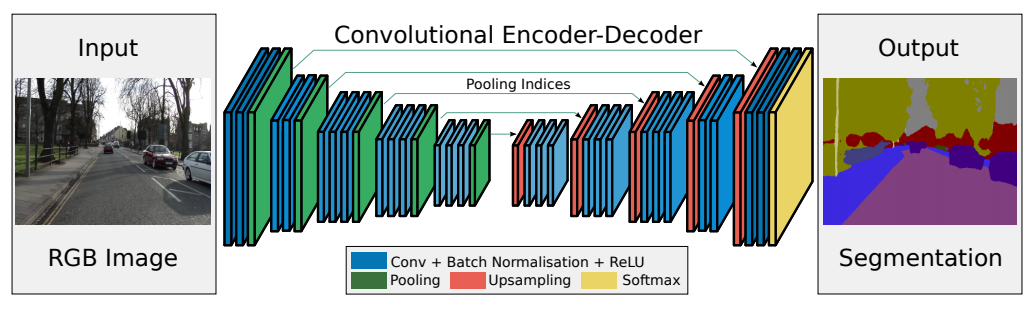


Построим архитектуру нашей сети - будет 5 блоков с 3 входами (включая, bottleneck) на кодирование информации и 5 блоков с 1 выходом на декодирование. На первых двух блоках и двух последних - будет два сверточных слоя с нормализацией, на 3 последних Downsampling и 3 первых Upsampling слоев будет 3 сверточных слоя. Количество фильтров будет возрастать от 64 до 512. Слой MaxPool2d будет возвращать индексы для слоев MaxUnpool2d

In [25]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = 3
        padding = 1
        pool = 2

        input = 3
        output = 1

        self.enc_conv0 = nn.Sequential(
            
                  nn.Conv2d(input, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv1 = nn.Sequential(
            
                  nn.Conv2d(64, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv2 = nn.Sequential(
            
                  nn.Conv2d(128, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv3 = nn.Sequential(
            
                  nn.Conv2d(256, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 

       
        # bottleneck

        self.bottleneck_conv = nn.Sequential(
            


                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU()
        )        
        self.pool4 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        # decoding
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool) 
        self.dec_conv0 =  nn.Sequential(
            
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU()
        )


        self.upsample1 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool) 
        self.dec_conv1 =  nn.Sequential(
            
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv2 =  nn.Sequential(
            
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv3 =  nn.Sequential(
            
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )
        self.upsample4 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv4 = nn.Sequential(
            
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, output, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(output),

        )

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, ind0 = self.pool0(x)
        size0 = x.size()
        
        x = self.enc_conv1(x)
        x, ind1 = self.pool1(x)
        size1 = x.size()

        x = self.enc_conv2(x)
        x, ind2 = self.pool2(x)
        size2 = x.size()

        x = self.enc_conv3(x)
        x, ind3 = self.pool3(x)
        size3 = x.size()
        
        # bottleneck
        x = self.bottleneck_conv(x)
        x, ind4 = self.pool4(x)

        # decoder
        x = self.upsample0(x, ind4, output_size=size3)
        x = self.dec_conv0(x)

        x = self.upsample1(x, ind3, output_size=size2)
        x = self.dec_conv1(x)

        x = self.upsample2(x, ind2, output_size=size1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, ind1, output_size=size0)
        x = self.dec_conv3(x)

        x = self.upsample4(x, ind0)
        x = self.dec_conv4(x)
        return x

### bce_loss_torch

#### Создание модели

In [26]:
model = load_models(pretrained_model_SegNet, SegNet)

# print(summary(model,(3, 256, 256)))   
# print(model)    

Файл модели не существует.


#### ОБУЧЕНИЕ

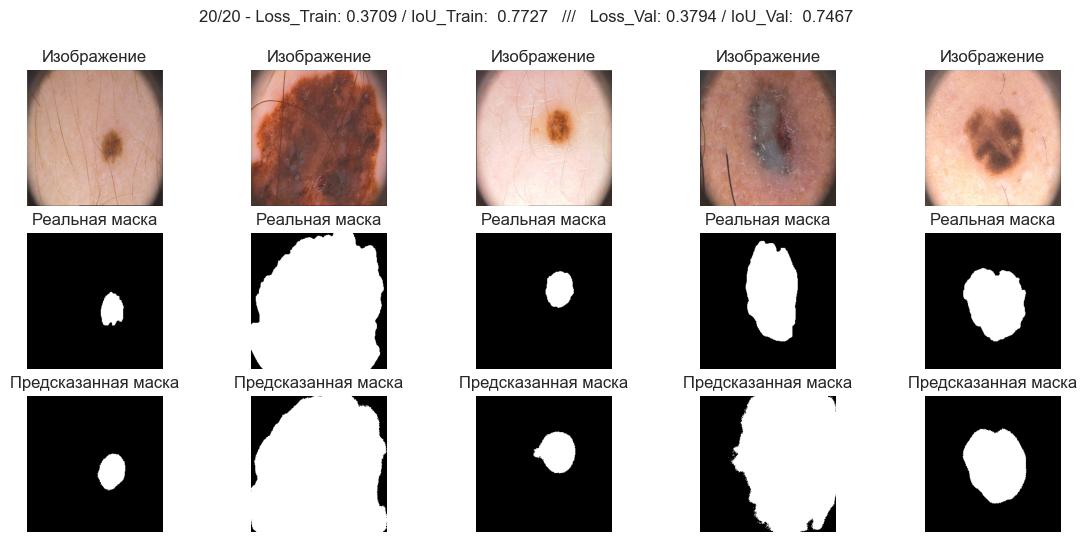

In [27]:
%time
start = time.time()

max_epochs = max_epochs

opt = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=17, gamma=0.1)

train(
      model, pretrained_model_SegNet, opt, bce_loss_torch, iou_pytorch, max_epochs, 
      data_tr, data_val, exp_lr_scheduler, 
      patience=17
      
      )

end = time.time()
elapsed = end - start

In [28]:
%%time
start_pred = time.time()


score = score_model(model, iou_pytorch, data_val)

end_pred = time.time()
elapsed_pred = end_pred - start_pred

CPU times: total: 359 ms
Wall time: 354 ms


In [29]:
score

0.7466666996479034

In [30]:
# Заносим данные обучения для статистики
IoU_test.append(score_model(model, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('bce_loss_torch')
train_time.append(elapsed)
prediction_time.append(elapsed_pred)

In [31]:
summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test }
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet')
)
summary

,Model,Loss,IoU_validation,IoU_test
0,SegNeT,bce_loss_torch,0.746667,0.680000


In [32]:
# Очищаем память
with torch.no_grad():
    torch.cuda.empty_cache()

In [33]:
!nvidia-smi

Tue Sep 12 12:13:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
| 44%   60C    P2              88W / 170W |   2851MiB / 12288MiB |     89%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Функция потерь  Dice coefficient

In [34]:
# Создание модели
model_dice = load_models(pretrained_model_SegNet, SegNet)

Модель успешно загружена и готова к использованию.


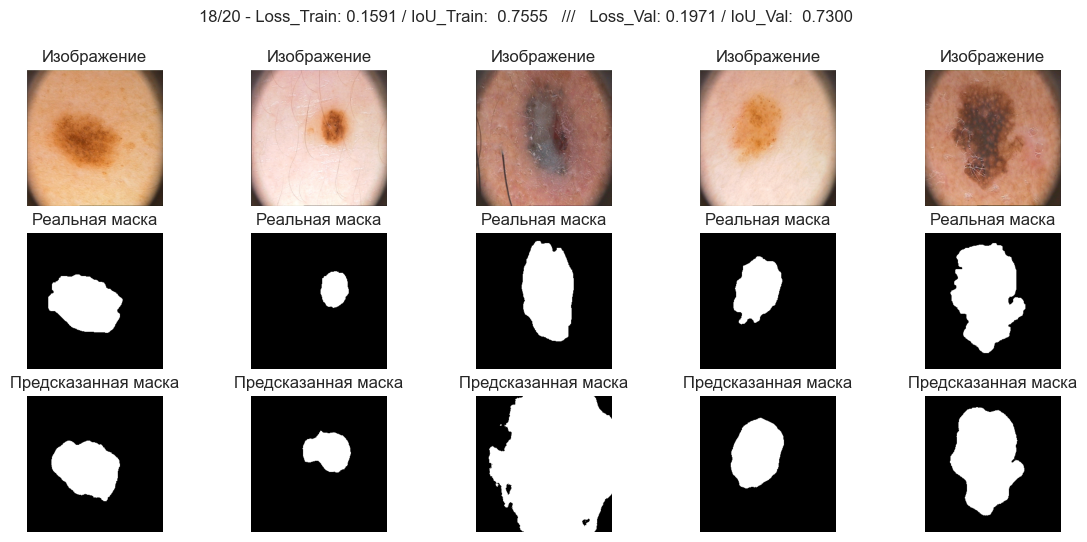

Epoch 19/20


Тренировка:   0%|          | 0/11 [00:00<?, ?it/s]

Валидация:   0%|          | 0/6 [00:00<?, ?it/s]

CPU times: total: 1min 57s
Wall time: 1min 56s


In [35]:
%%time
start = time.time()
# Обучение с функцией потерь Dice
max_epochs = max_epochs

optimaizer = optim.Adam(model_dice.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimaizer, step_size=17, gamma=0.1)
train(model_dice, pretrained_model_SegNet, optimaizer, dice_loss, iou_pytorch, max_epochs, 
      data_tr, data_val, exp_lr_scheduler, 
      patience=17)

end = time.time()
elapsed = end - start

In [36]:
%%time
start_pred = time.time()


score = score_model(model_dice, iou_pytorch, data_val)

end_pred = time.time()
elapsed_pred = end_pred - start_pred

CPU times: total: 422 ms
Wall time: 343 ms


In [37]:
score

0.45333334306875867

In [38]:
IoU_test.append(score_model(model_dice, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('dice_loss')

train_time.append(elapsed)
prediction_time.append(elapsed_pred)

In [39]:
summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test }
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet')
)
summary

,Model,Loss,IoU_validation,IoU_test
0,SegNeT,bce_loss_torch,0.746667,0.680000
1,SegNeT,dice_loss,0.453333,0.460000


In [40]:
with torch.no_grad():
    torch.cuda.empty_cache()

### Focal loss

In [41]:
# Создание модели
model_focal = load_models(pretrained_model_SegNet, SegNet)

Модель успешно загружена и готова к использованию.


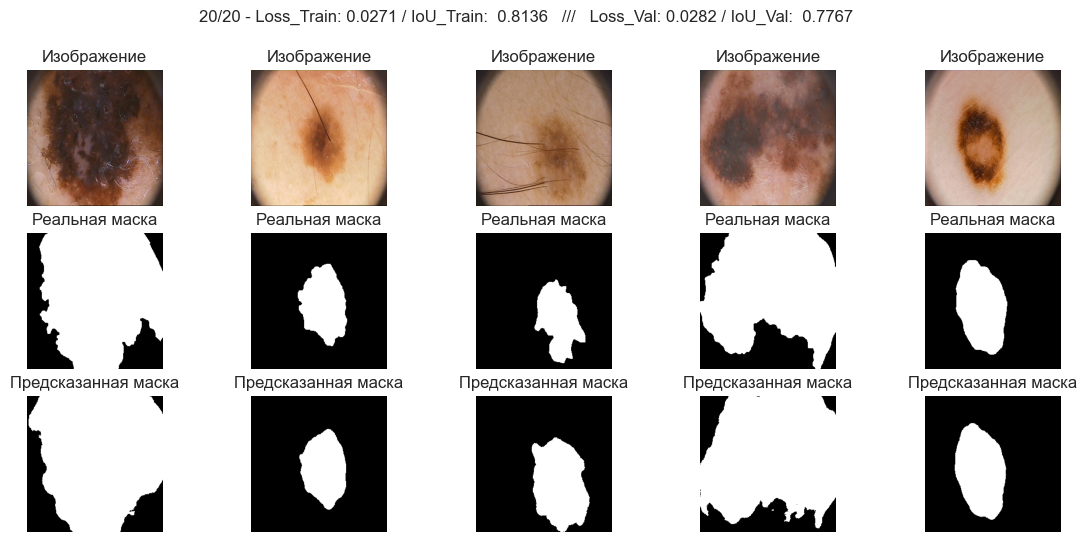

CPU times: total: 2min 5s
Wall time: 2min 3s


In [42]:
%%time

start = time.time()
max_epochs = max_epochs
optimaizer = optim.Adam(model_focal.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimaizer, step_size=17, gamma=0.1)
train(model_focal, pretrained_model_SegNet, optimaizer, focal_loss, iou_pytorch, max_epochs, 
      data_tr, data_val, exp_lr_scheduler, 
      patience=17)

end = time.time()
elapsed = end - start

In [43]:
%%time
start_pred = time.time()

score = score_model(model_focal, iou_pytorch, data_val)

end_pred = time.time()
elapsed_pred = end_pred - start_pred


CPU times: total: 328 ms
Wall time: 333 ms


In [44]:
score

0.7766667107741038

In [45]:
IoU_test.append(score_model(model_focal, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('focal_loss')
train_time.append(elapsed)
prediction_time.append(elapsed_pred)

In [46]:
summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test }
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet')
)
summary

,Model,Loss,IoU_validation,IoU_test
0,SegNeT,focal_loss,0.776667,0.720000
1,SegNeT,bce_loss_torch,0.746667,0.680000
2,SegNeT,dice_loss,0.453333,0.460000


In [47]:
with torch.no_grad():
    torch.cuda.empty_cache()

### lovasz_hinge

In [48]:
# Создание модели
model_lovasz = load_models(pretrained_model_SegNet, SegNet)


Модель успешно загружена и готова к использованию.


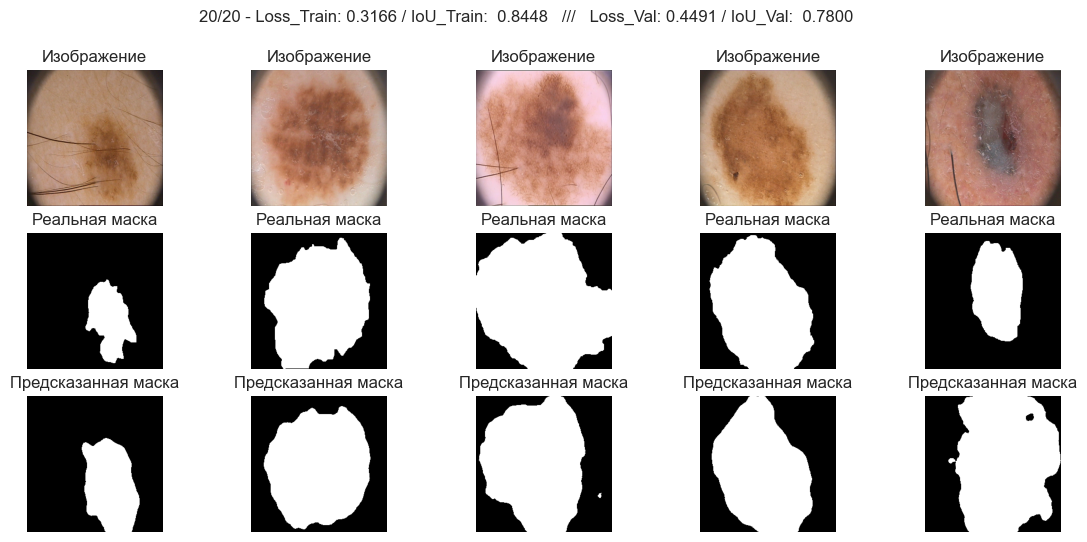

CPU times: total: 2min 6s
Wall time: 2min 3s


In [49]:
%%time
start = time.time()

max_epochs = max_epochs
optimaizer = optim.Adam(model_lovasz.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimaizer, step_size=17, gamma=0.1)
train(model_lovasz, pretrained_model_SegNet, optimaizer, lovasz_hinge, iou_pytorch, max_epochs, 
      data_tr, data_val, exp_lr_scheduler,
      patience=17)

end = time.time()
elapsed = end - start

In [50]:
%%time
start_pred = time.time()

score = score_model(model_lovasz, iou_pytorch, data_val)

end_pred = time.time()
elapsed_pred = end_pred - start_pred

CPU times: total: 359 ms
Wall time: 351 ms


In [51]:
score

0.7800000111262003

### ОТЧЁТ 

In [52]:
IoU_test.append(score_model(model_lovasz, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('lovasz_hinge')
train_time.append(elapsed)
prediction_time.append(elapsed_pred)

summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test }
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet')
)
summary

,Model,Loss,IoU_validation,IoU_test
0,SegNeT,lovasz_hinge,0.780000,0.760000
1,SegNeT,focal_loss,0.776667,0.720000
2,SegNeT,bce_loss_torch,0.746667,0.680000
3,SegNeT,dice_loss,0.453333,0.460000


In [53]:
with torch.no_grad():
    torch.cuda.empty_cache()

## U-Net

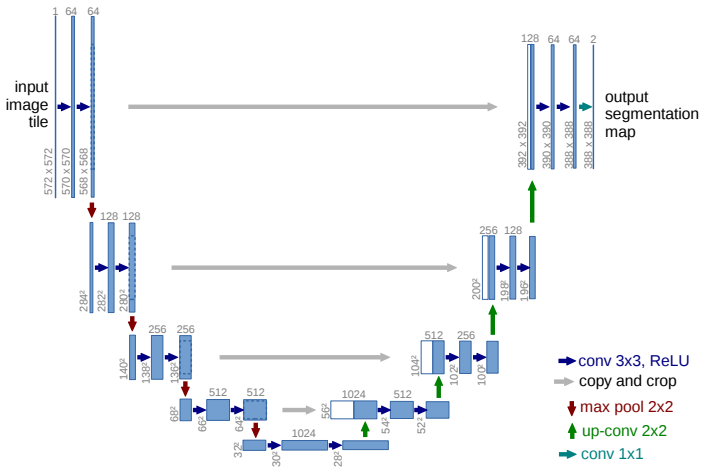

### U-Net базовая UpsamplingNearest2d

In [54]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = 3
        padding = 1
        pool = 2
        input = 3
        output = 1

        # encoder (downsampling)

        self.down_1 =  nn.Sequential(
            
                  nn.Conv2d(input, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(pool, stride=pool)

        self.down_2 =  nn.Sequential(
            
                  nn.Conv2d(64, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(pool, stride=pool)

        self.down_3 =  nn.Sequential(
            
                  nn.Conv2d(128, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(pool, stride=pool)
        self.down_4 =  nn.Sequential (
            
                  nn.Conv2d(256, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(pool, stride=pool)
       

        # bottleneck

        self.bottleneck_conv = nn.Sequential(
            


                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),

        )        
        
        # decoder (upsampling)

        self.upsample0 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv0 =  nn.Sequential(
            
                      nn.Conv2d(1024, 512, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
        )

        self.upsample1 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv1 =  nn.Sequential(
            
                      nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
        )

        self.upsample2 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv2 =  nn.Sequential(
            
                      nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
        )
 
        self.upsample3 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv3 =  nn.Sequential(
            
                  nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, output, kernel_size=1),
                  nn.BatchNorm2d(output)

        )


                   

    def forward(self, x):
        # encoder (downsampling)
        out_1 = self.down_1(x)
        out_pool_1 = self.pool1(out_1)

        out_2 = self.down_2(out_pool_1)
        out_pool_2 = self.pool2(out_2)

        out_3 = self.down_3(out_pool_2)
        out_pool_3 = self.pool3(out_3)

        out_4 = self.down_4(out_pool_3)
        out_pool_4 = self.pool4(out_4)

        # bottleneck

        bottleneck = self.bottleneck_conv(out_pool_4)

        # decoder (upsampling)
        up_1 = self.upsample0(bottleneck)
        up_out_1 = torch.cat((up_1, out_4), dim=1)
        out_5 = self.dec_conv0(up_out_1)


        up_2 = self.upsample1(out_5)
        up_out_2 = torch.cat((up_2, out_3), dim=1)
        out_6 = self.dec_conv1(up_out_2)

        up_3 = self.upsample2(out_6)
        up_out_3 = torch.cat((up_3, out_2), dim=1)
        out_7 = self.dec_conv2(up_out_3)

        up_4 = self.upsample3(out_7)
        up_out_4 = torch.cat((up_4, out_1), dim=1)
        preds = self.dec_conv3(up_out_4)
        return preds

#### ОБУЧЕНИЕ

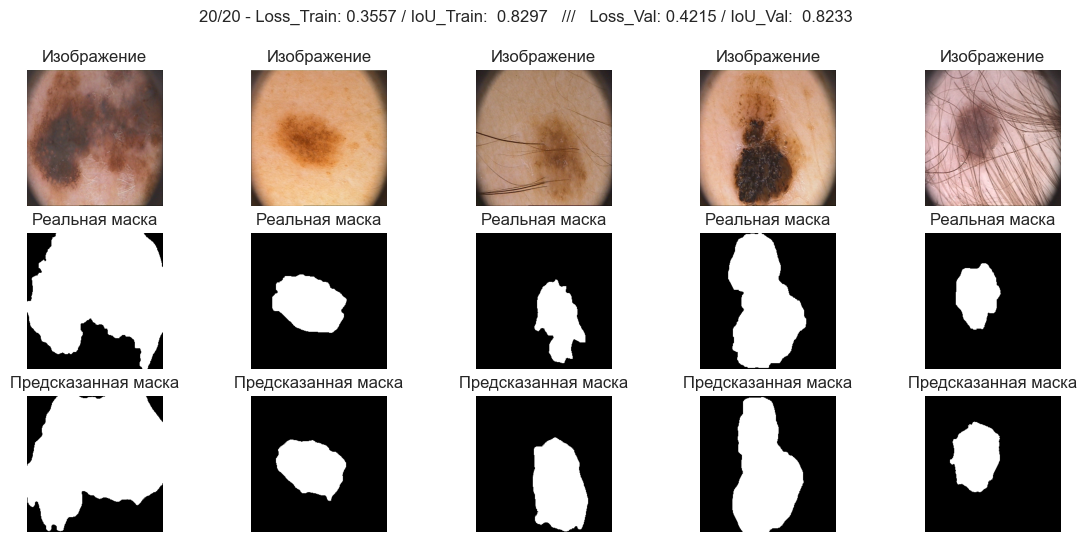

CPU times: total: 8min 10s
Wall time: 8min 1s


In [55]:
%%time
loss = [bce_loss_torch, dice_loss, focal_loss, lovasz_hinge]

IoU_validation_self = []
IoU_test_self = []
model_name_self = []
loss_name_self = []
train_time_self = []
prediction_time_self = []



for los in loss:
    print(f'Обучение модели U-Net на {los.__name__}')

    with torch.no_grad():
        torch.cuda.empty_cache()
    start = time.time()
    unet_model = load_models(pretrained_model_Unet1, UNet)  # Создание модели UNET
    
    
    
    
    max_epochs = max_epochs

    opt = optim.Adam(unet_model.parameters(), lr=1e-4)
    exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=17, gamma=0.1)

    train(
        unet_model, pretrained_model_Unet1, opt, los, iou_pytorch, max_epochs, 
        data_tr, data_val, exp_lr_scheduler, 
        patience=17
        )
    end = time.time()
        
    elapsed = end - start
    IoU_test.append(score_model(unet_model, iou_pytorch, data_ts))
    start_pred = time.time()
    IoU_validation.append(score_model(unet_model, iou_pytorch, data_val))
    end_pred = time.time()
    elapsed_pred = end_pred - start_pred
    model_name.append('U-Net UpsamplingNearest2d')
    loss_name.append(f'{los.__name__}')
    train_time.append(elapsed)
    prediction_time.append(elapsed_pred)

    #отдельный отчет на данный этап для удобства

    IoU_test_self.append(score_model(unet_model, iou_pytorch, data_ts))
    IoU_validation_self.append(score_model(unet_model, iou_pytorch, data_val))
    model_name_self.append('U-Net UpsamplingNearest2d')
    loss_name_self.append(f'{los.__name__}')
    train_time_self.append(elapsed)
    prediction_time_self.append(elapsed_pred)




    with torch.no_grad():
        torch.cuda.empty_cache()


  

    report = (pd.DataFrame({ 
        'Model' : model_name_self , 
        'Loss' : loss_name_self ,
        'IoU_validation' : IoU_validation_self ,
        'IoU_test' : IoU_test_self,
        'Train_time': train_time_self,
        'Prediction time': prediction_time_self}
        ).sort_values(by='IoU_test', ascending=False)
        .reset_index(drop=True)
        .assign(

            val_test_diff = lambda x: abs(1 - x['IoU_test'] / x['IoU_validation']) * 100
        )
        .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
        .highlight_max( 'IoU_validation' , color = 'grey' , axis = 0 )
        .highlight_min( 'val_test_diff' , color = 'blue' , axis = 0 )
        .set_caption('Сводная таблица результатов первичных испытания '
        ' для различных лосс-функций на архитектуре SeGNet и U-Net')

    )

In [56]:
report

,Model,Loss,IoU_validation,IoU_test,Train_time,Prediction time,val_test_diff
0,U-Net UpsamplingNearest2d,focal_loss,0.793333,0.740000,120.536674,0.315033,6.722690
1,U-Net UpsamplingNearest2d,bce_loss_torch,0.793333,0.710000,121.030847,0.321594,10.504202
2,U-Net UpsamplingNearest2d,lovasz_hinge,0.823333,0.710000,120.579757,0.317034,13.765184
3,U-Net UpsamplingNearest2d,dice_loss,0.683333,0.570000,115.561403,0.328998,16.585368


In [57]:
IoU_test.append(score_model(model_lovasz, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('lovasz_hinge')
train_time.append(elapsed)
prediction_time.append(elapsed_pred)

summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test }
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet')
)
summary

,Model,Loss,IoU_validation,IoU_test
0,SegNeT,lovasz_hinge,0.780000,0.760000
1,SegNeT,lovasz_hinge,0.780000,0.760000
2,U-Net UpsamplingNearest2d,focal_loss,0.793333,0.740000
3,SegNeT,focal_loss,0.776667,0.720000
4,U-Net UpsamplingNearest2d,bce_loss_torch,0.793333,0.710000
5,U-Net UpsamplingNearest2d,lovasz_hinge,0.823333,0.710000
6,SegNeT,bce_loss_torch,0.746667,0.680000
7,U-Net UpsamplingNearest2d,dice_loss,0.683333,0.570000
8,SegNeT,dice_loss,0.453333,0.460000


### U-Net с ConvTranspose2d

#### Модель

In [58]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_1 = self.downsampling_(3, 64)
        self.down_2 = self.downsampling_(64, 128)
        self.down_3 = self.downsampling_(128, 256)
        self.down_4_bottle = self.bottleneck_conv(256, 512)

        self.upsample1 = self.upsampling_(512, 256)
        self.upsample2 = self.upsampling_(256, 128)
        self.upsample3 = self.upsampling_(128, 64)

        self.preds = nn.Sequential(
            nn.ConvTranspose2d(
                64, 1, kernel_size=3, padding=1, stride=2, output_padding=1
            )
        )

    def downsampling_(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )


    def bottleneck_conv(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU()

        )       
  

    def upsampling_(self, in_chan, out_chan):
        return nn.ModuleList(
            [
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size=3,
                                   stride=2, padding=1, output_padding=1),
              # обязательно задать на первый модуль output_padding - определяет форму вывода
                nn.BatchNorm2d(2 * out_chan),
                nn.ReLU(),
                nn.ConvTranspose2d(2 * out_chan, out_chan, kernel_size=3,
                                   stride=1, padding=1),
              # обязательно задать stride = 1, вместо 2 - иначе на вход следующему слою придет меньше фильтров
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
            ]
        )

    def forward(self, x):
        out_1 = self.down_1(x)
        out_2 = self.down_2(out_1)
        out_3 = self.down_3(out_2)
        out_4 = self.down_4_bottle(out_3)


        up_out_1 = self.upsample1[0](out_4)
        up_out_1 = torch.cat([out_3, up_out_1], dim=1)
        for out_ in self.upsample1[1:]:
            up_out_1 = out_(up_out_1)

        up_out_2 = self.upsample2[0](up_out_1)
        up_out_2 = torch.cat([out_2, up_out_2], dim=1)
        for out_ in self.upsample2[1:]:
            up_out_2 = out_(up_out_2)

        up_out_3 = self.upsample3[0](up_out_2)
        up_out_3 = torch.cat([out_1, up_out_3], dim=1)
        for out_ in self.upsample3[1:]:
            up_out_3 = out_(up_out_3)
     

        preds = self.preds(up_out_3)
        return preds

#### Обучение

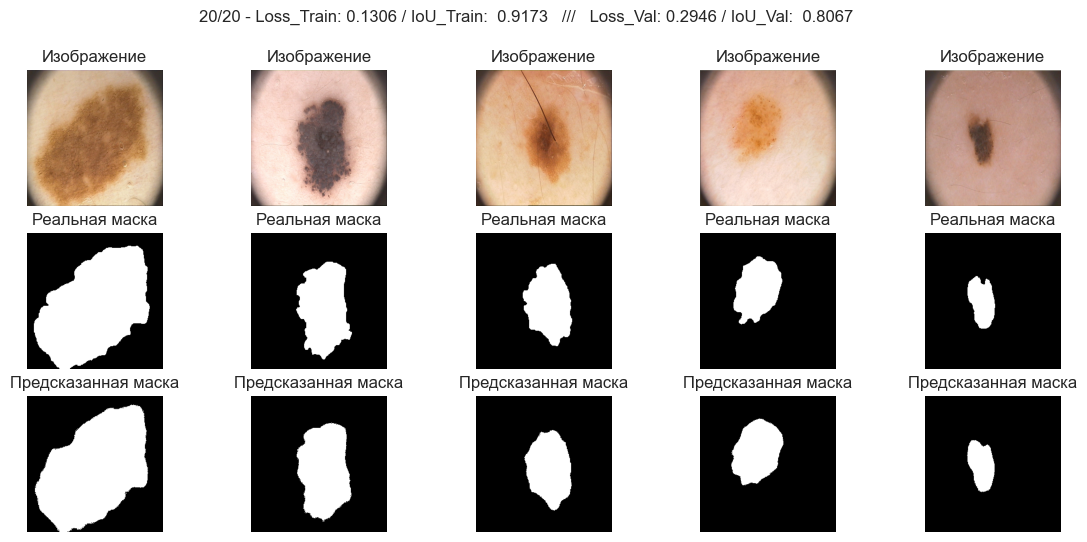

CPU times: total: 5min 38s
Wall time: 5min 28s


In [59]:
%%time
loss = [bce_loss_torch, dice_loss, focal_loss, lovasz_hinge]

IoU_validation_self = []
IoU_test_self = []
model_name_self = []
loss_name_self = []
train_time_self = []
prediction_time_self = []



for los in loss:
  print(f'Обучение модели U-Net на {los.__name__}')

  with torch.no_grad():
    torch.cuda.empty_cache()
  start = time.time()
  unet2_model = load_models(pretrained_model_Unet2, UNet2)  # Создание модели UNET
  max_epochs = max_epochs

  opt = optim.Adam(unet2_model.parameters(), lr=1e-4)
  exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=17, gamma=0.1)

  train(
        unet2_model, pretrained_model_Unet2, opt, los, iou_pytorch, max_epochs, 
        data_tr, data_val, exp_lr_scheduler, 
        patience=17
        
        )
  end = time.time()
  elapsed = end - start
  IoU_test.append(score_model(unet2_model, iou_pytorch, data_ts))
  start_pred = time.time()
  IoU_validation.append(score_model(unet2_model, iou_pytorch, data_val))
  end_pred = time.time()
  elapsed_pred = end_pred - start_pred
  model_name.append('U-Net ConvTranspose2d')
  loss_name.append(f'{los.__name__}')
  train_time.append(elapsed)
  prediction_time.append(elapsed_pred)

  #отдельный отчет на данный этап для удобства

  IoU_test_self.append(score_model(unet2_model, iou_pytorch, data_ts))
  IoU_validation_self.append(score_model(unet2_model, iou_pytorch, data_val))
  model_name_self.append('U-Net ConvTranspose2d')
  loss_name_self.append(f'{los.__name__}')
  train_time_self.append(elapsed)
  prediction_time_self.append(elapsed_pred)




  with torch.no_grad():
    torch.cuda.empty_cache()


  

  report_ct = (pd.DataFrame({ 
    'Model' : model_name_self , 
    'Loss' : loss_name_self ,
    'IoU_validation' : IoU_validation_self ,
    'IoU_test' : IoU_test_self,
    'Train_time': train_time_self,
    'Prediction time': prediction_time_self}
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .assign(
        
        val_test_diff = lambda x: abs(1 - x['IoU_test'] / x['IoU_validation']) * 100
    )
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .highlight_max( 'IoU_validation' , color = 'grey' , axis = 0 )
    .highlight_min( 'val_test_diff' , color = 'blue' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet и U-Net')
    
)

In [60]:
report_ct

,Model,Loss,IoU_validation,IoU_test,Train_time,Prediction time,val_test_diff
0,U-Net ConvTranspose2d,lovasz_hinge,0.806667,0.820000,83.020040,0.201970,1.652901
1,U-Net ConvTranspose2d,dice_loss,0.796667,0.800000,81.010186,0.203003,0.418412
2,U-Net ConvTranspose2d,bce_loss_torch,0.776667,0.800000,81.562096,0.202982,3.004291
3,U-Net ConvTranspose2d,focal_loss,0.783333,0.760000,80.275913,0.207000,2.978724


In [61]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Итоговый  Отчёт

In [62]:
# Итоговый отчёт
summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test,
    'Train_time': train_time,
    'Prediction_time': prediction_time}
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .assign(
        
        val_test_diff = lambda x: abs(1 - x['IoU_test'] / x['IoU_validation']) * 100
    )
    
)

In [63]:
summary

,Model,Loss,IoU_validation,IoU_test,Train_time,Prediction_time,val_test_diff
0,U-Net ConvTranspose2d,lovasz_hinge,0.806667,0.82,83.020040,0.201970,1.652890
1,U-Net ConvTranspose2d,dice_loss,0.796667,0.80,81.010186,0.203003,0.418415
2,U-Net ConvTranspose2d,bce_loss_torch,0.776667,0.80,81.562096,0.202982,3.004293
3,U-Net ConvTranspose2d,focal_loss,0.783333,0.76,80.275913,0.207000,2.978723
4,SegNeT,lovasz_hinge,0.780000,0.76,123.771425,0.351335,2.564105
5,SegNeT,lovasz_hinge,0.780000,0.76,120.579757,0.317034,2.564105
6,U-Net UpsamplingNearest2d,focal_loss,0.793333,0.74,120.536674,0.315033,6.722690
7,SegNeT,focal_loss,0.776667,0.72,123.723894,0.332998,7.296135
8,U-Net UpsamplingNearest2d,bce_loss_torch,0.793333,0.71,121.030847,0.321594,10.504201
9,U-Net UpsamplingNearest2d,lovasz_hinge,0.823333,0.71,120.579757,0.317034,13.765179


## Проверка моделей на тестовом наборе

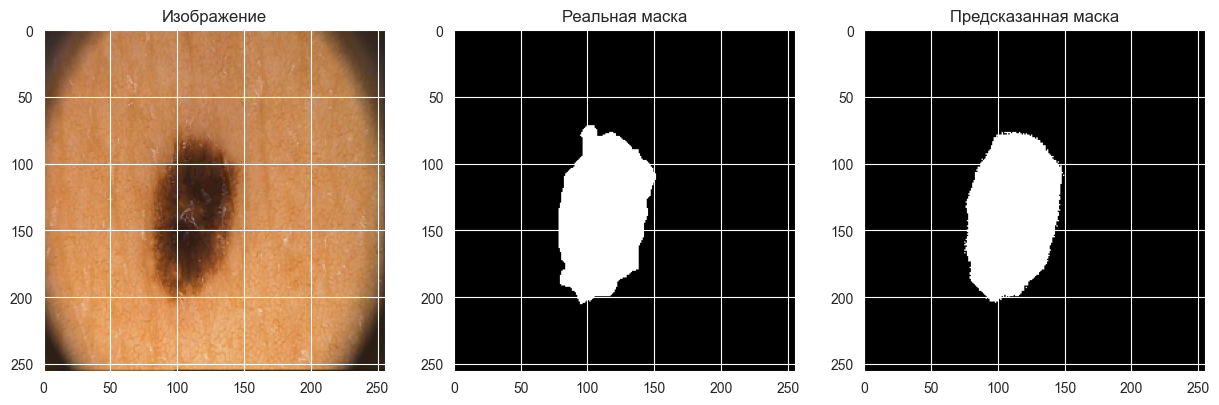

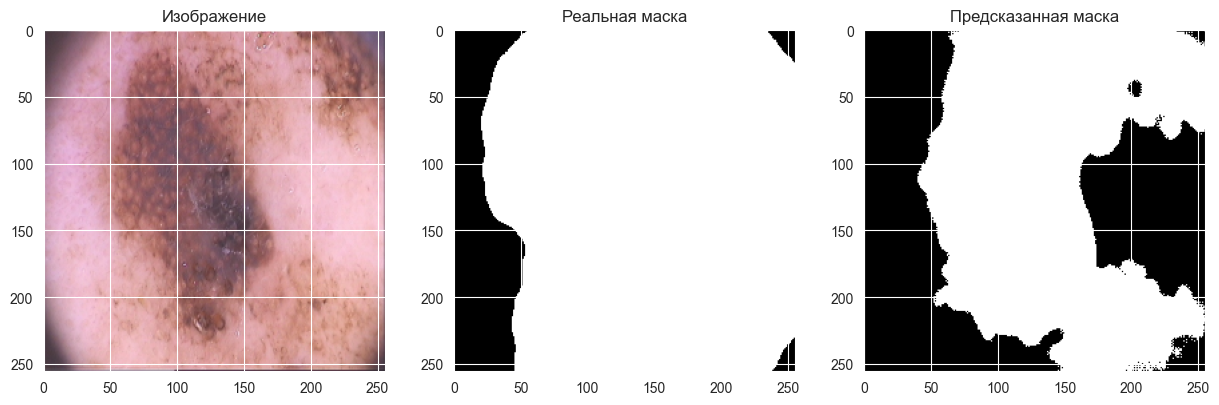

In [64]:
predict(unet2_model, data_ts, F.sigmoid)

In [65]:
with torch.no_grad():
    torch.cuda.empty_cache()  #очистить ресурсы  GPU